# Model Exploration

Testing the use of OpenAI APIs to simplify the image before implementing contour finding.

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 07/01/2026   | Martin | Created   | Notebook to explore the use of OpenAI image generation models | 
| 22/01/2026   | Martin | Update   | Pivoted to using OpenAI API for style transfer | 
| 28/01/2026   | Martin | Update   | Explored using the generated image to simplify the image first | 

# Content

* [Introduction](#introduction)
* [Contours on AI Images](#contours-on-ai-images)
* [Test OpenAI Generation](#test-openapi-generation)

# Introduction

Use OpenAI's models to simplify the image and create more definable contours before defining the numbered regions

# Contours on AI Images

Using the contour function on AI processed image to check performance of workflow

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colornames

from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import label2rgb

In [16]:
def load_image(img_path: str, encoding: str="BGR"):
  try:
    img = cv2.imread(img_path)
    if encoding == "RGB":
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
  except FileNotFoundError:
    print("Could not find the file to load")

In [ ]:
def superpixel_segmentation(
  img: np.array,
  n_segments: int = 200,
  compactness: int = 10,
  sigma: int = 1
):
  height, width, _ = img.shape
  segments = slic(
    img,
    n_segments=n_segments,
    compactness=compactness,
    sigma=sigma,
    start_label=1
  )

  superpixel_img = label2rgb(
    segments,
    img,
    kind='avg'
  )

  return superpixel_img


In [ ]:
def get_colours(
  img: np.array,
  n_clusters: int = 10
):
  height, width, _ = img.shape
  pixel_list = img.reshape((img.shape[0] * img.shape[1], 3))

  clt = KMeans(n_clusters=n_clusters, n_init="auto")
  clt.fit(pixel_list)

  # Extract colours
  d_colours = clt.cluster_centers_.astype('uint8') # Cluster centers - RGB values
  labels = clt.labels_ # Assigned cluster center by index
  new_img = d_colours[labels] # Extracted colours

  # Reshape back to original image
  new_img = new_img.reshape((height, width, 3))

  # Get the colour names
  d_colours_l = d_colours.tolist()
  colour_names = {}
  for i, colour in enumerate(d_colours_l):
    colour_names[i+1] = (colornames.find(colour[0], colour[1], colour[2]), colour)

  return new_img, colour_names, labels

In [100]:
def create_canvas(
  img: np.array,
  labels: np.array,
  n_clusters: int = 10,
  min_area_ratio: float = 0.0005,
):
  height, width, _ = img.shape

  # Define scales for text details
  scale = max(height, width) / 1000.0
  font_scale = 0.6 * scale
  font_thickness = max(1, int(1 * scale))
  contour_thickness = max(1, int(1 * scale))

  # Define the minimum threshold for colour areas
  # keeps only those areas which are `min_area_ratio`% of the entire image size
  min_area_threshold = int((height * width) * min_area_ratio)

  # PBN canvas
  labels_grid = labels.reshape((height, width))
  canvas = np.ones((height, width, 3), dtype='uint8') * 255
  label_position_mask = np.zeros((height, width), dtype='uint8')

  for colour_id in range(n_clusters):
    # Binary mask - 255 if matches, 0 if not
    mask = np.where(labels_grid == colour_id, 255, 0).astype('uint8')

    # Find the contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
      if cv2.contourArea(contour) > min_area_threshold:
        # Draw the contours on the canvas
        cv2.drawContours(canvas, [contour], -1, (150, 150, 150), contour_thickness)

        # Try the center region for each cluster for each colour
        M = cv2.moments(contour)
        if M["m00"] != 0:
          center_X = int(M["m10"] / M["m00"])
          center_Y = int(M["m01"] / M["m00"])
        else:
          center_X, center_Y = contour[0][0]

        # Check if point is within the contour
        # dist >0: inside, <0: outside, =0: on edge
        # if outside, find distance that is furthest from all contour boundaries
        if cv2.pointPolygonTest(contour, pt=(center_X, center_Y), measureDist=False) < 0:
          dist_mask = np.zeros((height, width), dtype='uint8')
          cv2.drawContours(dist_mask, [contour], -1, 255, -1)
          dist_transform = cv2.distanceTransform(
            dist_mask,
            distanceType=cv2.DIST_L2,
            maskSize=3
          )
          _, _, _, max_loc = cv2.minMaxLoc(dist_transform)
          center_X, center_Y = max_loc
        
        # Text settings
        current_font_scale = font_scale
        placed = False

        # trying 3 sizes of fonts scaled accordingly
        for s in [1.0, 0.7, 0.4]:
          temp_scale = current_font_scale * s
          text = str(colour_id+1)
          (text_width, text_height), _ = cv2.getTextSize(
            text,
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=temp_scale,
            thickness=font_thickness
          )

          text_x, text_y = center_X - (text_width // 2), center_Y + (text_height // 2)

          # boundary check
          if text_x < 0 or text_x + text_width >= width or text_y - text_height < 0 or text_y >= height:
            continue
          
          # overlap check
          roi = label_position_mask[text_y-text_height:text_y, text_x:text_x+text_height]
          if np.any(roi):
            continue

          # containment check
          corners = [(text_x, text_y), (text_x+text_width, text_y), (text_x, text_y-text_height), (text_x+text_width, text_y-text_height)]
          if all(cv2.pointPolygonTest(contour, pt, False) >= 0 for pt in corners):
            cv2.putText(
              canvas,
              text=text,
              org=(text_x, text_y),
              fontFace=cv2.FONT_HERSHEY_SIMPLEX,
              fontScale=temp_scale,
              color=(0, 0, 0),
              thickness=font_thickness
            )
            label_position_mask[text_y-text_height:text_y, text_x:text_x+text_width] = 255
            placed = True
            break
        
        # If still not placed, force into best spot with smallest font
        if not placed:
          small_scale = current_font_scale * 0.3
          cv2.putText(
            canvas,
            text=str(colour_id+1),
            org=(center_X, center_Y),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=small_scale,
            color=(50, 50, 50),
            thickness=1
          )

  return canvas


In [114]:
type(pbn)

numpy.ndarray

{1: ('Buccaneer', [110, 35, 51]), 2: ('Cerulean Blue', [50, 95, 181]), 3: ('Havelock Blue', [65, 131, 198]), 4: ('Revolver', [36, 17, 43]), 5: ('Cosmic', [119, 61, 110]), 6: ('Gigas', [70, 61, 128]), 7: ('Cerulean Blue', [46, 70, 171]), 8: ('Tall Poppy', [182, 50, 33]), 9: ('Gull Gray', [156, 170, 186]), 10: ('Martinique', [63, 32, 70])}


(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

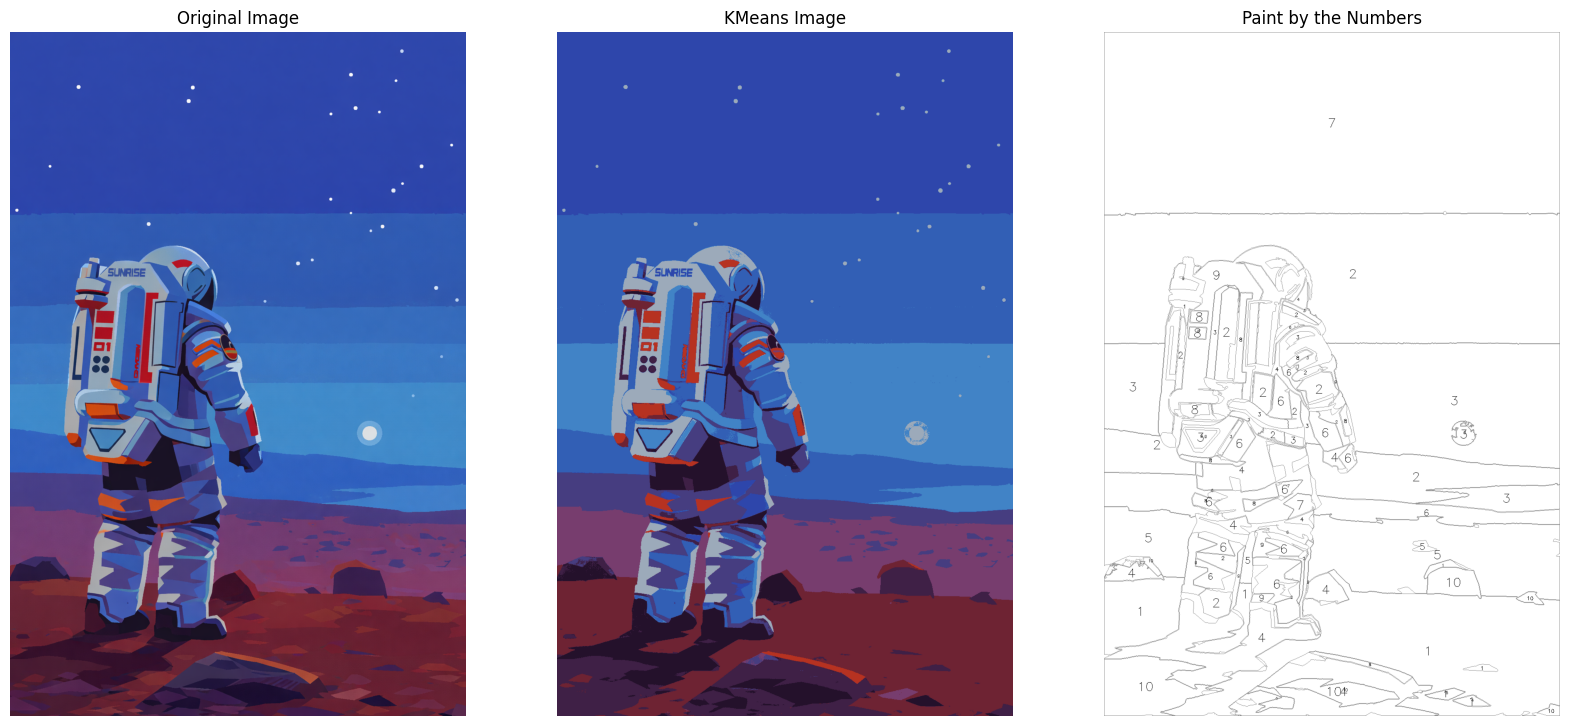

In [ ]:
img = load_image("./data/ai_1.png", "RGB")
# img = superpixel_segmentation(img)
new_img, colours, labels = get_colours(img, 10)
pbn = create_canvas(new_img, labels)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
ax1.imshow(img)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(new_img)
ax2.set_title("KMeans Image")
ax2.axis("off")

ax3.imshow(pbn)
ax3.set_title("Paint by the Numbers")
ax3.axis("off")

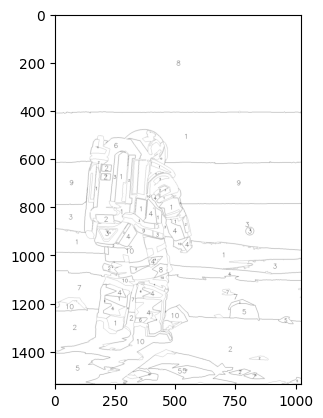

In [102]:
plt.imshow(pbn)

In [63]:
# colours = colours.tolist()
colour_names = {colornames.find(c[0], c[1], c[2]): c for c in colours}
print(colour_names)

{'Cerulean Blue': [50, 95, 181], 'Buccaneer': [116, 37, 49], 'Mountbatten Pink': [141, 120, 137], 'Revolver': [48, 24, 54], 'Havelock Blue': [65, 131, 198], 'Cosmic': [119, 60, 110], 'Honey Flower': [69, 60, 126], 'Spindle': [190, 208, 229], 'Gull Gray': [151, 166, 181]}


# Test OpenAPI Generation


In [5]:
import os
from openai import OpenAI
from dotenv import dotenv_values

In [6]:
# Load my openai key
config = dotenv_values(".env")
os.environ['OPENAI_API_KEY'] = config['OPENAI_API_KEY']

In [7]:
client = OpenAI()

response = client.responses.create(
  model="gpt-5.2",
  input="Write a one-sentence story about my glorious king Stephen Wardell Curry"
)

print(response.output_text)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [1]:
%load_ext watermark
%watermark

Last updated: 2026-01-07T16:05:53.032499+08:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.37.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.6.87.2-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

